In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

In [2]:
from sklearn.datasets import fetch_openml
# Загружаем датасет MNIST из OpenML (70000 примеров, 784 признака - это 28*28)
dmf = fetch_openml('mnist_784', version=1)

In [3]:
# 1. Загрузка данных
X, y = dmf["data"], dmf["target"]
# 3. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Преобразование меток y в формат one-hot
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(pd.DataFrame(y))
y_one_hot[y_one_hot == 0] = -1

X_scaled = X_scaled.reshape(-1, 1, 28, 28)

# 5. Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.4, random_state=42)

y_train_class = encoder.inverse_transform(y_train)
y_test_class = encoder.inverse_transform(y_test)

In [4]:
from sklearn.manifold import TSNE

In [5]:
# tsne = TSNE(n_components=2, random_state=0)
# x_tsne = tsne.fit_transform(X_test.reshape((-1, 28 * 28)))

In [6]:
# # Визуализация результатов
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test_class, cmap='tab10', alpha=0.7)
# plt.colorbar(scatter, ticks=range(10), label="Цифры")
# plt.title("Визуализация MNIST с использованием t-SNE")
# plt.xlabel("t-SNE компонент 1")
# plt.ylabel("t-SNE компонент 2")
# plt.show()

# Модель

In [7]:
from NeuralNetwork import NeuralNetwork
from Functions import mse, dmse, Functions, rng
from LayerTypes import LayerTypes, create_layer

In [8]:
net_arch_mnist = ((20,5,5), (2,12,12), (10,3,3), (2, 5, 5), 20, 10)
NN = NeuralNetwork([
        create_layer(LayerTypes.CONVOLUTIONAL, kernel_count=net_arch_mnist[0][0],
                     kernel_size=(5, 5), input_size=(1, 28, 28),
                     activation_function=Functions.relu),
        create_layer(LayerTypes.POOLING, pool_size=2),
        create_layer(LayerTypes.CONVOLUTIONAL, kernel_count=net_arch_mnist[2][0],
                     kernel_size=(3, 3), input_size=(net_arch_mnist[0][0], 12, 12),
                     activation_function=Functions.relu),
        create_layer(LayerTypes.POOLING, pool_size=2),
        create_layer(LayerTypes.FLATTEN),
        create_layer(LayerTypes.DENSE, input_size=250, output_size=20, activation_function=Functions.tanh),
        create_layer(LayerTypes.DENSE, input_size=20, output_size=10, activation_function=Functions.tanh)
    ], 0.07)


In [9]:
loss = NN.fit(X_train, y_train, 3, batch_size=128)

100%|██████████| 3/3 [05:32<00:00, 110.79s/it]


In [10]:
loss

array([0.00136453, 0.00035971, 0.00024523])

In [11]:
class Metrics:

  def __init__(self, y_pred, y):
    self.confusion_matrix = self._init_confusion_matrix(y_pred, y)
    self.accuracy = np.trace(self.confusion_matrix) \
                    / np.sum(self.confusion_matrix)
    confusion_matrix = self.confusion_matrix
    # Инициализируем списки для precision, recall и F1 для каждого класса
    precision = []
    recall = []
    f1_score = []

    # Рассчитываем метрики для каждого класса
    for i in range(len(self.confusion_matrix)):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        # Precision, Recall, F1 для класса i
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

        print(f"Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1-Score = {f1:.4f}")
    self.precision = precision
    self.recall = recall
    self.f1_score = f1_score

  def _init_confusion_matrix(self, y_pred, y):
    n = max(np.max(y_pred), np.max(y)) + 1
    matrix = np.zeros((n, n))
    for i in range(len(y_pred)):
      pred_class = y_pred[i]
      class_label = y[i]
      matrix[pred_class, class_label] += 1
    return matrix

In [12]:
batch_size = 128
data = X_test[:10000]
y_data = y_test_class[:10000]
batch = data[0:batch_size]
res_proba = NN.forward(batch)
for i in range(batch_size, len(data), batch_size):
    batch = data[i:i+batch_size]
    res_batch = NN.forward(batch)
    res_proba = np.append(res_proba, res_batch, axis=0)
res_proba

array([[-0.99942433, -0.98010233, -0.99845038, ..., -0.99696234,
         0.97298639, -0.97461947],
       [-0.99999591, -0.98364143, -0.99503032, ..., -0.995111  ,
        -0.9873171 , -0.99820663],
       [-0.99591063, -0.9883774 , -0.99980624, ..., -0.99770166,
         0.80805022, -0.996058  ],
       ...,
       [-0.99614059, -0.9964039 , -0.96425459, ..., -0.99262529,
        -0.98930587, -0.9562698 ],
       [-0.99246954, -0.99846454, -0.96238938, ..., -0.97572762,
         0.52595196, -0.93632762],
       [-0.99746782, -0.99351699, -0.95346163, ..., -0.97899376,
        -0.98945865, -0.97912658]])

['8']


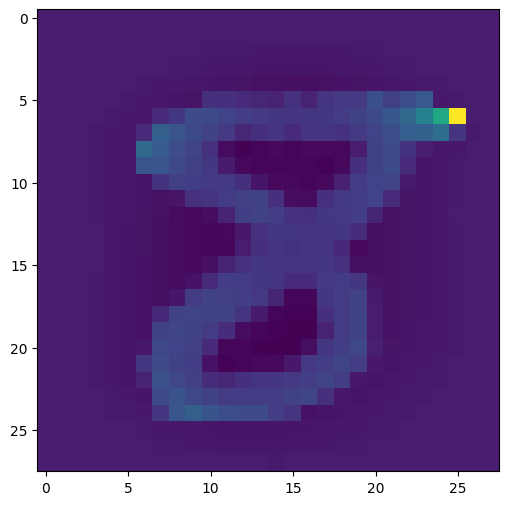

In [13]:
i = 0
plt.imshow(X_test[i].reshape(28, 28))
print((y_test_class[i]))

In [14]:
res_proba_max = res_proba.argmax(axis=1)
res_proba_max

array([8, 4, 8, ..., 3, 8, 3], dtype=int64)

In [15]:
y_data = y_data.astype(np.uint8)

In [16]:
y_test_class = y_test_class.astype(np.uint8)

In [17]:
metrics = Metrics(res_proba_max, y_data)
pd.DataFrame(metrics.confusion_matrix)

Class 0: Precision = 0.9664, Recall = 0.9694, F1-Score = 0.9679
Class 1: Precision = 0.9731, Recall = 0.9964, F1-Score = 0.9846
Class 2: Precision = 0.9679, Recall = 0.8940, F1-Score = 0.9295
Class 3: Precision = 0.9603, Recall = 0.9229, F1-Score = 0.9412
Class 4: Precision = 0.9470, Recall = 0.9717, F1-Score = 0.9592
Class 5: Precision = 0.9338, Recall = 0.9669, F1-Score = 0.9501
Class 6: Precision = 0.9553, Recall = 0.9766, F1-Score = 0.9658
Class 7: Precision = 0.9431, Recall = 0.9784, F1-Score = 0.9604
Class 8: Precision = 0.9360, Recall = 0.9116, F1-Score = 0.9236
Class 9: Precision = 0.9527, Recall = 0.9564, F1-Score = 0.9545


,0,1,2,3,4,5,6,7,8,9
0,950.0,0.0,0.0,2.0,0.0,6.0,10.0,1.0,7.0,4.0
1,0.0,1121.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15.0,15.0,936.0,19.0,9.0,2.0,9.0,21.0,19.0,2.0
3,1.0,4.0,9.0,993.0,3.0,29.0,0.0,9.0,17.0,11.0
4,0.0,3.0,2.0,0.0,858.0,1.0,4.0,5.0,1.0,9.0
5,2.0,0.0,1.0,3.0,2.0,875.0,9.0,2.0,7.0,4.0
6,6.0,2.0,3.0,0.0,8.0,3.0,918.0,0.0,0.0,0.0
7,1.0,1.0,4.0,5.0,1.0,0.0,0.0,995.0,3.0,7.0
8,6.0,5.0,9.0,9.0,7.0,21.0,11.0,8.0,907.0,12.0
9,2.0,1.0,1.0,3.0,18.0,0.0,0.0,13.0,7.0,987.0


In [18]:
metrics.accuracy

0.954